In [ ]:
#import sys
#!{sys.executable} -m pip install matplotlib
#import sys
#!{sys.executable} -m pip install numpy
#import sys
#!{sys.executable} -m pip install pandas
#import sys
#!{sys.executable} -m pip install seaborn
#import sys
#!{sys.executable} -m pip install tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


#col_names = ["GlaThiDa_ID", "POLITICAL_UNIT", "GLACIER_NAME", "SURVEY_DATE", "PROFILE_ID", "POINT_ID", 
#"POINT_LAT", "POINT_LON", "ELEVATION", "THICKNESS", "THICKNESS_UNCERTAINTY", "DATA_FLAG"]

#raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/TTT.csv")

raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")

#,sep='\t', lineterminator='\r'
#, header=None, error_bad_lines=False)

dataset = raw_dataset.copy()






2.6.0


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
#examine missing data
dataset.tail()


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
3854274,6630,AT,MULLWITZKEES,19989999.0,NaN,27,47.092690,12.380504,3329.0,36,4.0,NaN,NaN
3854275,6630,AT,MULLWITZKEES,19989999.0,NaN,28,47.093780,12.379642,3353.0,26,3.0,NaN,NaN
3854276,6630,AT,MULLWITZKEES,19989999.0,NaN,29,47.094839,12.378200,3381.0,39,4.0,NaN,NaN
3854277,6630,AT,MULLWITZKEES,19989999.0,NaN,30,47.094829,12.378174,3381.0,39,4.0,NaN,NaN
3854278,6631,AT,MULLWITZKEES,20039999.0,NaN,1,47.094853,12.374525,3369.0,50,5.0,NaN,NaN


In [3]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("PROFILE_ID", axis=1)
dataset = dataset.drop("POINT_ID", axis=1)
dataset = dataset.drop("THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("REMARKS", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

POINT_LAT         0
POINT_LON         0
ELEVATION    481445
THICKNESS         0
dtype: int64

In [4]:
#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()


POINT_LAT    0
POINT_LON    0
ELEVATION    0
THICKNESS    0
dtype: int64

# 

In [5]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

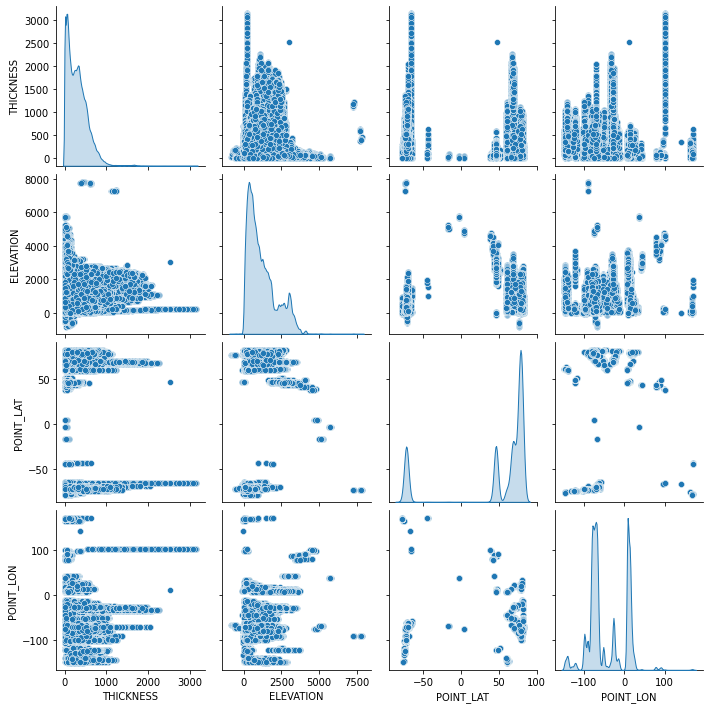

In [6]:
sns.pairplot(train_dataset[["THICKNESS", "ELEVATION", "POINT_LAT", "POINT_LON"]], diag_kind='kde')

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
POINT_LAT,2698267.0,47.477816,53.238428,-78.305458,46.405156,70.346832,78.809574,82.963377
POINT_LON,2698267.0,-46.458083,45.484560,-149.046814,-78.210226,-67.742430,7.805468,170.284390
ELEVATION,2698267.0,1175.033891,937.446613,-839.000000,431.000000,898.000000,1686.000000,7846.000000
THICKNESS,2698267.0,295.750914,243.823599,0.000000,96.000000,259.000000,435.000000,3151.000000


In [8]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("THICKNESS")
test_labels = test_features.pop("THICKNESS")

In [9]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
POINT_LAT,47.477816,53.238428
POINT_LON,-46.458083,45.484560
ELEVATION,1175.033891,937.446613


In [10]:
#pfm function to normalize data to the mean

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [11]:
#mean values to which pfm will adjust each individual datum

print(normalizer.mean.numpy())

[[  47.478  -46.458 1175.015]]


In [12]:
#pfm & comparison of before and after

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[-72.56 -70.   333.  ]]

Normalized: [[-2.25 -0.52 -0.9 ]]


In [13]:
train_features

,POINT_LAT,POINT_LON,ELEVATION
3339651,-72.564441,-69.998971,333.0
2943153,81.867034,-77.017853,1081.0
2657681,66.433727,-35.430230,1296.0
3064407,78.118836,-80.193036,949.0
2240074,76.954024,-67.192816,1121.0
...,...,...,...
1289740,79.978951,19.964506,542.0
220814,45.958592,7.402746,2695.0
3416043,69.411009,-27.024702,2322.0
3694651,-70.252527,-70.028377,67.0


In [25]:
#begin linear regression with elevation

#put training features into numpy array and apply normalization layer
array_int = np.array(train_features)
elevation = np.array(train_features["ELEVATION"])

elevation_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
elevation_normalizer.adapt(elevation)

In [26]:
#build elevation model with Sequential
elevation_model = tf.keras.Sequential([
    elevation_normalizer,
    layers.Dense(units=1)
])

elevation_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [27]:
#pfm to predict thickness from elevation data
elevation_model.predict(elevation[:10])

array([[ 0.874],
       [ 0.098],
       [-0.126],
       [ 0.235],
       [ 0.056],
       [ 0.972],
       [ 0.199],
       [-0.055],
       [-0.341],
       [-0.14 ]], dtype=float32)

In [28]:
#more pfm
elevation_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [40]:
#run the actual model
#%%time
history_ele = elevation_model.fit(
    train_features["ELEVATION"], train_labels,
    epochs=2,
    # suppress logging
#    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/2
67457/67457 [==============================] - 27s 400us/step - loss: 175.1606 - val_loss: 175.3616
Epoch 2/2
67457/67457 [==============================] - 27s 403us/step - loss: 175.1612 - val_loss: 175.3602


In [31]:
hist_ele = pd.DataFrame(history_ele.history)
hist_ele['epoch'] = history_ele.epoch
hist_ele.tail()

,loss,val_loss,epoch
0,176.956497,175.364578,0
1,175.161087,175.362762,1


In [34]:
ele_test_results = {}

ele_test_results['elevation_model'] = elevation_model.evaluate(
    test_features['ELEVATION'],
    test_labels, verbose=0)

ele_test_results['elevation_model']

174.95021057128906

In [35]:
# x = tf.linspace(0.0, 250, 251)
# y = elevation_model.predict(x)

predicted_thickness = elevation_model.predict(test_features['ELEVATION'])

Text(0, 0.5, 'Predicted Thickness')

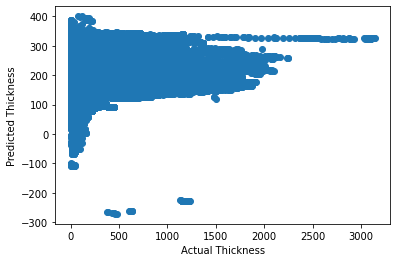

In [36]:
plt.subplots()
plt.plot(test_labels,predicted_thickness,'o')
plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')

In [37]:
def plot_elevation(x, y):
  plt.scatter(train_features['ELEVATION'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Elevation')
  plt.ylabel('Thickness')
  plt.legend()

In [38]:
plot_elevation(x,y)

NameError: name 'x' is not defined

In [ ]:
#Linear regression with latitude

latitude = np.array(train_features['POINT_LAT'])

latitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
latitude_normalizer.adapt(latitude)


latitude_model = tf.keras.Sequential([
    latitude_normalizer,
    layers.Dense(units=1)
])

#latitude_model.summary()

latitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')



In [ ]:
%%time
history_lat = latitude_model.fit(
    train_features['POINT_LAT'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist_lat = pd.DataFrame(history_lat.history)
hist_lat['epoch'] = history.epoch
hist_lat.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['latitude_model'] = latitude_model.evaluate(
    test_features['POINT_LAT'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LAT'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
#Linear regression with longitude

longitude = np.array(train_features['POINT_LON'])

longitude_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
longitude_normalizer.adapt(latitude)


longitude_model = tf.keras.Sequential([
    longitude_normalizer,
    layers.Dense(units=1)
])

#longitude_model.summary()

longitude_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = longitude_model.fit(
    train_features['POINT_LON'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['longitude_model'] = longitude_model.evaluate(
    test_features['POINT_LON'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = latitude_model.predict(x)

In [ ]:
def plot_elevation(x, y):
  plt.scatter(train_features['POINT_LON'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Latitude')
  plt.ylabel('Thickness')
  plt.legend()

In [ ]:
plot_elevation(x,y)

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
#pfm function using multivariable regression

linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Thickness]')
  plt.legend()
  plt.grid(True)

plot_loss(history)